In [0]:
import random
import torch
import torch.nn.functional as F

random.seed(42)

In [0]:
with open("/Workspace/Users/hitesh.meena@renew.com/RNN/mlp/names.txt", "r") as f:
    all_names = f.read().splitlines()


In [0]:
#names 
print(all_names[:8])
print(f"Total names: {len(all_names)}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Total names: 35879


In [0]:
all_chars = sorted(list(set("".join(all_names))))

stoi = {ch:i+1 for i, ch in enumerate(all_chars)}
stoi["."] = 0

itos = {value: key for key, value in stoi.items()}

In [0]:
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [0]:
CONTEXT_WINDOW = 3

def build_dataset(names):
    X, Y = [], []

    for name in names:
        # print(f"name: {name}")
        extended_name  = "..." + name + "."
        # print(f"extended name: {extended_name}")
        for idx in range(len(extended_name)-CONTEXT_WINDOW):
            in_char = extended_name[idx:idx+CONTEXT_WINDOW]
            out_char = extended_name[idx+CONTEXT_WINDOW]
            # print(f"{in_char} ---> {out_char}")
            X.append([stoi[x] for x in list(in_char)])
            Y.append(stoi[out_char])
        # print("_"*30)

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print("X,Y shapes: ", X.shape, Y.shape)

    return X, Y

random.shuffle(all_names)
n1 = int(len(all_names)*0.8)
n2 = int(len(all_names)*0.9)

Xtrain, Ytrain = build_dataset(all_names[:n1])
Xval, Yval = build_dataset(all_names[n1:n2])
Xtest, Ytest = build_dataset(all_names[n2:])

X,Y shapes:  torch.Size([205216, 3]) torch.Size([205216])
X,Y shapes:  torch.Size([25876, 3]) torch.Size([25876])
X,Y shapes:  torch.Size([25550, 3]) torch.Size([25550])


In [0]:
n_embed = 10
n_hidden = 200
VOCAB = 27

In [0]:
for idx in range(5):
    print(f"x: {Xtrain[idx]} --> y: {Ytrain[idx]}")

x: tensor([0, 0, 0]) --> y: 19
x: tensor([ 0,  0, 19]) --> y: 9
x: tensor([ 0, 19,  9]) --> y: 25
x: tensor([19,  9, 25]) --> y: 1
x: tensor([ 9, 25,  1]) --> y: 14


# MLP Network 

In [0]:
input_size_1 = CONTEXT_WINDOW * n_embed

lrs = [0.1, 0.01, 0.001]

epochs = 200000
batch_size = 32

# Initalize Weights and biases

In [0]:
gen = torch.Generator().manual_seed(2147483647)

C = torch.randn((VOCAB, n_embed),          generator=gen)

w1 = torch.randn((input_size_1, n_hidden), generator=gen) * 0.2
b1 = torch.randn(n_hidden,                 generator=gen) * 0.01

w2 = torch.randn((n_hidden, VOCAB),        generator=gen) * 0.01
b2 = torch.randn(VOCAB,                    generator=gen) * 0

parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad=True

In [0]:
sum(p.nelement() for p in parameters)

11897

### forward pass

In [0]:
for epoch in range(epochs):

    # Minibatch
    sample = torch.randint(0, Xtrain.shape[0], (batch_size,))
        
    # Forward Pass
    emb = torch.reshape(C[Xtrain[sample]], (batch_size, (CONTEXT_WINDOW * n_embed)))
    hpreac = emb @ w1 + b1
    out = torch.tanh(hpreac)
    logits = out @ w2 + b2

    for p in parameters:
        p.grad = None
    # Loss
    loss = F.cross_entropy(logits, Ytrain[sample])
    loss.backward()

    if epoch < 50000:
        lr = lrs[0]
    elif epoch < 10000:
        lr = lrs[1]
    else:
        lr = lrs[2]

    # update
    for p in parameters:
        p.data += - lr * p.grad
    
    if epoch % 5000 == 0:
        print(f"{epoch=} loss: {loss.item():.4f}")

epoch=0 loss: 3.2235
epoch=5000 loss: 2.1374
epoch=10000 loss: 2.1353
epoch=15000 loss: 2.2252
epoch=20000 loss: 2.2011
epoch=25000 loss: 2.4298
epoch=30000 loss: 2.4434
epoch=35000 loss: 2.0030
epoch=40000 loss: 2.1063
epoch=45000 loss: 2.0263
epoch=50000 loss: 2.1585
epoch=55000 loss: 2.1776
epoch=60000 loss: 2.2916
epoch=65000 loss: 1.7496
epoch=70000 loss: 1.8921
epoch=75000 loss: 2.3981
epoch=80000 loss: 2.0755
epoch=85000 loss: 1.9425
epoch=90000 loss: 2.1245
epoch=95000 loss: 2.1079
epoch=100000 loss: 2.2253
epoch=105000 loss: 2.2174
epoch=110000 loss: 2.3121
epoch=115000 loss: 1.8959
epoch=120000 loss: 2.1013
epoch=125000 loss: 1.6222
epoch=130000 loss: 2.1612
epoch=135000 loss: 2.2270
epoch=140000 loss: 1.9882
epoch=145000 loss: 2.5178
epoch=150000 loss: 2.2280
epoch=155000 loss: 1.9242
epoch=160000 loss: 2.3170
epoch=165000 loss: 2.3437
epoch=170000 loss: 1.9475
epoch=175000 loss: 2.1511
epoch=180000 loss: 2.2528
epoch=185000 loss: 1.9386
epoch=190000 loss: 1.8189
epoch=19500

In [0]:
split_data = {
    "train": (Xtrain, Ytrain),
    "test": (Xtest, Ytest),
    "valid": (Xval, Yval)
}

@torch.no_grad()
def split_loss(Xdata, Ydata, split):

    emb = torch.reshape(C[Xdata], (Xdata.shape[0], (CONTEXT_WINDOW * n_embed)))
    out = torch.tanh(emb @ w1 + b1)
    logits = out @ w2 + b2

    for p in parameters:
        p.grad = None
    # Loss
    loss = F.cross_entropy(logits, Ydata)
    print(f"split: {split} loss: {loss.item():.4f}")

split_loss(*split_data["train"], "train")
split_loss(*split_data["test"], "test")
split_loss(*split_data["valid"], "valid")

split: train loss: 3.2326
split: test loss: 3.2330
split: valid loss: 3.2329


In [0]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(200):
    
    out = []
    context = [0] * CONTEXT_WINDOW # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      if ix == 0:
        break
      out.append(ix)
    
    print(''.join(itos[i] for i in out))

cexzm
zoglkurkioqzktyhwbvlzimjtnainrlkfukzkktda
rfmxvpubjtbhrmgotzx
iczixqctxujkwptedogkkjemkmmsidguenkbvgynywftbspmhwcivgbvtahlvsu
dsdxxblnwglhpynw
igwnjwrpfdwipkwzkm
desu
firmt
gbiksjbhuabsvoth
kuysxqevmcmrbxmtwyhfkjenvxmvpfkmlmghfvjzxobojysoxhgbptjapxweegpfwhccfyzfvksiiqmvwbhmiwqmduzqsamjhgamcxemmk
isbcxfmbalcslhh
fpyzvasvz
bqzazeenschck
wnkojuoxyvtvfiwkkddugnkul
fuwfcgjz
arl
j
nuuutstofgqzudbo
rdubpknumd
vxfacdvaaasjzjkdh
gh
frdklhahflrklmlcugro
pnxhwyx
vn
gixgosfqc
mempfnclfxtirbkhpjfdwhzymalerzgvmzjvtjuifbooovnkcxlkvrmjafcie
xoraw

veigtbcaamnnf
chfeukwowseadjjkkswrcpawhoxskfikw
scynndtiuxxwoturzhqnsjdndszuockexiegzzulhnqdqwosi
kdrnfjvmtthtpzzmdvvhvtptaqlhdnkj
zxkcbrzsrcagitwicvkcqiotgnvpllciqs
uohjxnvxqikebadkdawdfwwea
fqcnmrloljlpjldyjehpprjpssmkznhrmmyoadmsod
dnvzcomtzfikidecxjhbmmjxqphvtedjbwkxzyisndnoauiycrdfetifkvzlzf
ud
ckndsgyldqbkcylrozgwkjgftrahdrndapspdayna
thavpgelvlfqxxsdabgxlyzv
ikzvrykvyxhuj
qkkwkuaics
xxqubplmqguhbpnetz

tfscppboipyvqyrccekoodxengwalyrfviiutynlydw

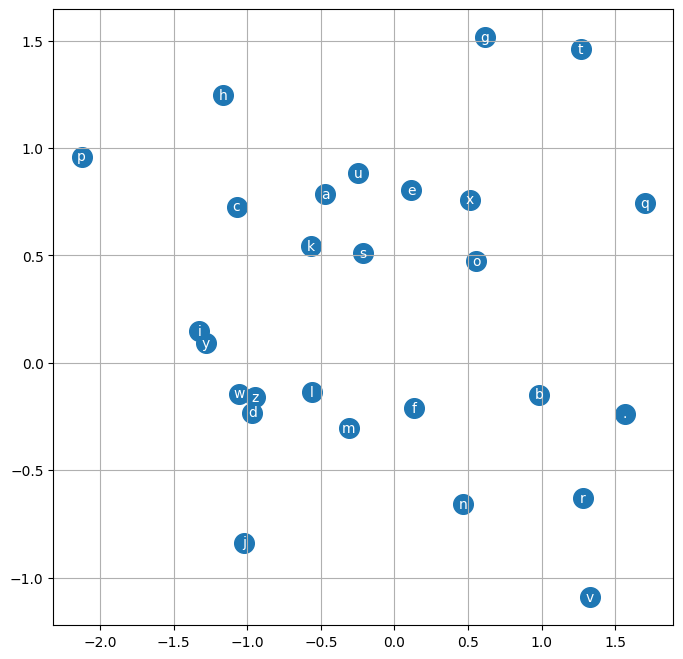

In [0]:
import matplotlib.pyplot as plt

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [0]:
logits = torch.tensor([1/27]*27)

In [0]:
F.softmax(logits)

/root/.ipykernel/4858/command-2671760361290144-383899727:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logits)


tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

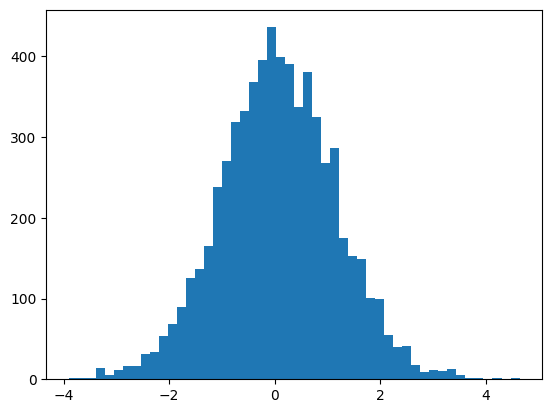

In [0]:
plt.hist(hpreac.view(-1).tolist(),bins=50)
plt.show()

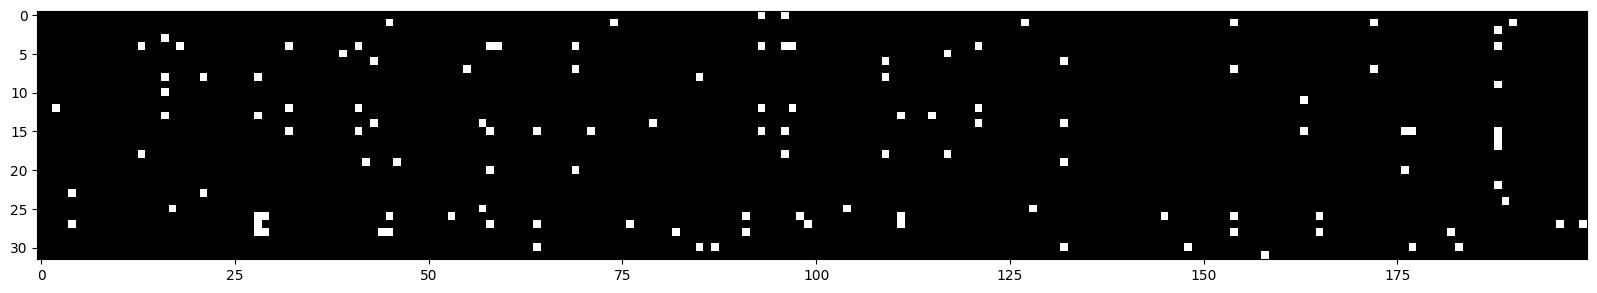

In [0]:
plt.figure(figsize=(20,10))
plt.imshow(out.abs() > 0.99, cmap="gray", interpolation="nearest" )